# setting

## path

In [14]:
import sys, os
home_path = os.path.expanduser("~")
sys.path.append(home_path + '/Desktop/Credit_Comp/py/models/')
sys.path.append(home_path + '/Desktop/Credit_Comp/py/')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg')

## module

使用するモジュールをimport

In [15]:
import numpy as np # linear algebra
import pandas as pd # data processing
import pandas_profiling as pdp
from collections import Counter
import Base, Classifier # my module
# genetic algorithm
from deap import algorithms, base, creator, tools, gp
import operator, math, time
from tqdm import tqdm
# optuna
from functools import partial
import optuna
# sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.externals.six import StringIO
# Boosting
from xgboost import XGBClassifier
import lightgbm as lgb
# view
import pydotplus
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

In [16]:
# moduleの再読み込み(作業中に更新した内容をここで更新できる)
import importlib
importlib.reload(Base)
importlib.reload(Classifier)

<module 'Classifier' from '/Users/takutokotsubo/Desktop/Credit_Comp/py/models/Classifier.py'>

In [17]:
# for instance
Process = Base.Process()
Applicate = Base.Applicate()
LightGBM = Classifier.LightGBM()
DecisionTree = Classifier.DecisionTree()

## read data

In [18]:
# using data
train, test, target = Process.read_data1()
# select features
features = test.columns.values # 暫定的

27000 observations and 24 features in train set.
3000 observations and 23 features in test set.


# eda

In [8]:
# 欠損値の確認
Applicate.missing_value(train)

,y,X23,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X1
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# 簡単なレポート作成
profile = pdp.ProfileReport(train)
file_name = home_path + '/Desktop/Credit_Comp/output/report/train_data_profile.html'
profile.to_file(outputfile = file_name)

# Detail

## クレジット金額と支払い履行の関係性

少額を踏み倒している?

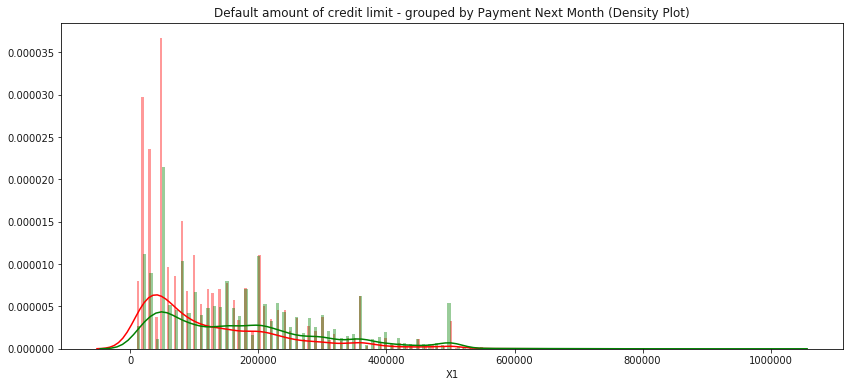

In [9]:
class_0 = train.loc[train['y'] == 0]['X1']
class_1 = train.loc[train['y'] == 1]['X1']
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

## 年齢と支払い履行の関係性

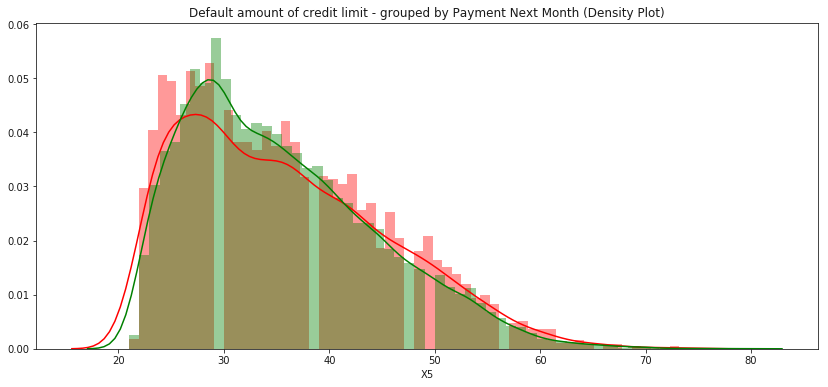

In [10]:
class_0 = train.loc[train['y'] == 0]['X5']
class_1 = train.loc[train['y'] == 1]['X5']
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=60, color="red")
sns.distplot(class_0,kde=True,bins=60, color="green")
plt.show()

## カテゴリカル変数のクロス集計 

In [11]:
print("性別（1=男性, 2=女性)")
print(pd.crosstab(index=train["X2"],columns=train["y"]))
print("教育（1=大学院, 2=大学, 3=高校, 0,4,5,6=その他）")
print(pd.crosstab(index=train["X3"],columns=train["y"]))
print("婚姻状況（1=既婚, 2=単身, 3=離婚, 0=その他）")
print(pd.crosstab(index=train["X4"],columns=train["y"]))

性別（1=男性, 2=女性)
y       0     1
X2             
1    8126  2591
2   12880  3403
教育（1=大学院, 2=大学, 3=高校, 0,4,5,6=その他）
y      0     1
X3            
0     12     0
1   7671  1834
2   9633  3013
3   3317  1117
4    105     6
5    226    18
6     42     6
婚姻状況（1=既婚, 2=単身, 3=離婚, 0=その他）
y       0     1
X4             
0      42     4
1    9402  2904
2   11348  3010
3     214    76


# Feature Correlation

## 支払い記録の相関

1ヶ月ごとに遅れていくので, 相関が生まれやすい

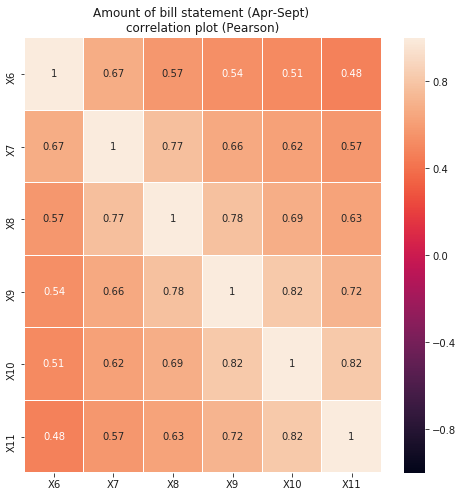

In [12]:
var = ["X6","X7","X8","X9","X10","X11"]
plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,annot=True)
plt.show()

## 請求明細書の相関

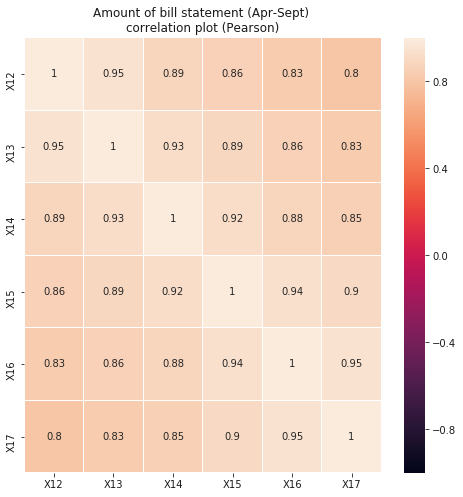

In [13]:
var = ["X12","X13","X14","X15","X16","X17"]
plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,annot=True)
plt.show()

# Algorithm Selection

- 複数のモデル等を適用してみて, 今後の方針を考える.
- 関数化(Classifier.py)して, 適宜書き換える

## Decision tree

In [14]:
# execute model
param = {
    'random_state': 831,
    'max_depth': 5,
    'criterion': 'gini'
}
clf = DecisionTreeClassifier(**param)
clf = clf.fit(train.drop("y",axis=1), train["y"])
# predict value
predict = clf.predict(test)
predict
# sample submit
# Process.submit(predict,tech="simple_decision_tree")

array([0, 0, 0, ..., 0, 1, 0])

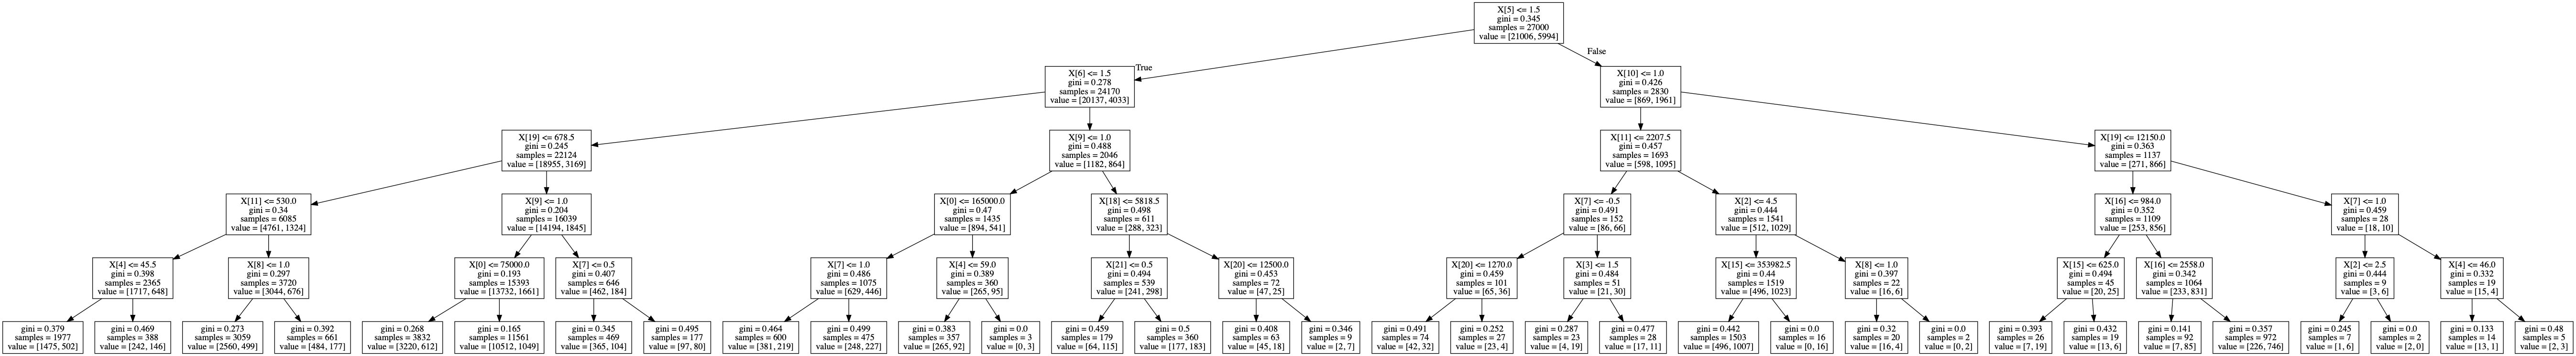

In [15]:
# tree view
DecisionTree.display_tree(clf)

## Compare Some Models

- DecisionTree
- RandamForest
- AdaBoost
- GradientBoosting
- XGBoost
- LightGBM

In [40]:
# classifier list for the normal training set
clf_list = [DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"), 
            RandomForestClassifier(n_estimators = 100, class_weight = "balanced"), 
            AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3,                
                                                      class_weight = "balanced"),
                               n_estimators = 100), 
            GradientBoostingClassifier(), 
            XGBClassifier()
           ]
# use Kfold to evaluate the normal training set
kf = KFold(n_splits=5,random_state=831,shuffle=True)

# ans box
ans = pd.DataFrame(columns=['model','fold','score'])

In [41]:
# validation some models classifier
for i,(trn_index, val_index) in enumerate(kf.split(train)):
    # set data
    training = train.iloc[trn_index][features]
    valid = train.iloc[val_index][features]
    trn_target = train.iloc[trn_index]['y']
    val_target = train.iloc[val_index]['y']
    # cross validation
    print("fold n°{}".format(i+1))
    for clf in clf_list:
        name = clf.__class__.__name__ # model name 
        clf.fit(training,trn_target) # model execute
        pred = clf.predict(valid) # predict validation
        score = f1_score(y_true = val_target, y_pred = pred) # score
        tmp = pd.Series( [name, i+1, score], index=ans.columns )
        ans = ans.append( tmp, ignore_index=True )
        print(name)
# result
print(ans)

fold n°1
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°2
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°3
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°4
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°5
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
                         model fold     score
0       DecisionTreeClassifier    1  0.514390
1       RandomForestClassifier    1  0.460860
2           AdaBoostClassifier    1  0.492329
3   GradientBoostingClassifier    1  0.481888
4                XGBClassifier    1  0.476295
5       DecisionTreeClassifier    2  0.522108
6       RandomForestClassifier    2  0.466412
7           AdaBoostClassifier    2  0.510526
8   GradientBoostingClassifier    2  0.475780
9                XGBClassifier    2  0.474429
10      DecisionTreeClassifier    3  0.517328
11      RandomForestClassifier    3  0.448164
12          AdaBoostClassifier    3  0.510252
13  GradientBoostingClassifier    3  0.482315
14               XGBClassifier    3  0.478752
15      DecisionTreeClassifier    4  0.518016
16      RandomForestClassifier    4  0.442675
17          AdaBoostClassifier    4  0.497831
18  GradientBoostingClassifier    4  0.474895
19               XGBClassifier    4  0.474541
20      DecisionTree

In [7]:
# validation lightgbm classifier
param = Process.open_parameter(file_name = 'lgb_classifer_param')
lgb_ans, importances = LightGBM.validation(train,features,param)
print(lgb_ans)

fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.150231	valid_1's binary_error: 0.177037
[200]	training's binary_error: 0.121574	valid_1's binary_error: 0.178148
Early stopping, best iteration is:
[21]	training's binary_error: 0.173472	valid_1's binary_error: 0.17463
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.151065	valid_1's binary_error: 0.177778
[200]	training's binary_error: 0.122824	valid_1's binary_error: 0.179074
Early stopping, best iteration is:
[35]	training's binary_error: 0.169259	valid_1's binary_error: 0.175926
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.151389	valid_1's binary_error: 0.179815
[200]	training's binary_error: 0.120602	valid_1's binary_error: 0.182222
Early stopping, best iteration is:
[53]	training's binary_error: 0.163287	valid_1's binary_error: 0.178148
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.148056	valid_1's binary_error: 0.185926
[200]	training's binary_error: 0.121759	valid_1's binary_error: 0.18963
Early stopping, best iteration is:
[96]	training's binary_error: 0.148657	valid_1's binary_error: 0.184815
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.150463	valid_1's binary_error: 0.17963
[200]	training's binary_error: 0.122361	valid_1's binary_error: 0.180741
[300]	training's binary_error: 0.09625	valid_1's binary_error: 0.182407
Early stopping, best iteration is:
[139]	training's binary_error: 0.138565	valid_1's binary_error: 0.178333
   fold                model     score
0     1  Lightgbm Classifier  0.463290
1     2  Lightgbm Classifier  0.486486
2     3  Lightgbm Classifier  0.488842
3     4  Lightgbm Classifier  0.479666
4     5  Lightgbm Classifier  0.483092


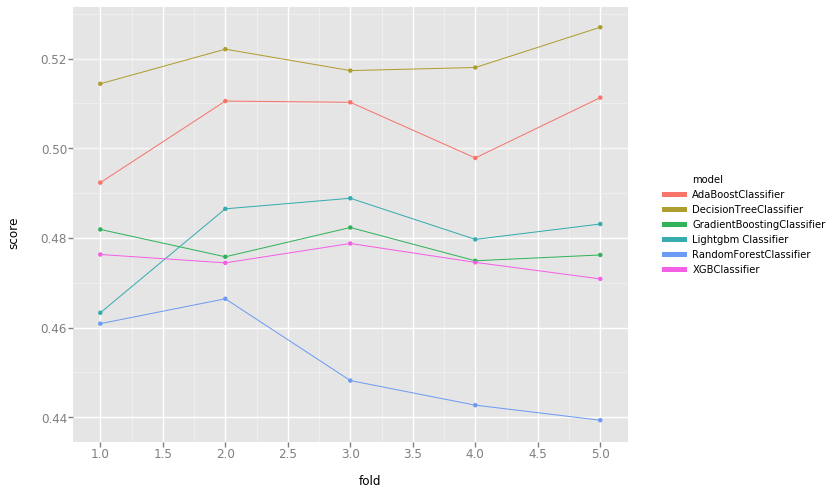

<ggplot: (-9223372036568180564)>


In [46]:
#create a small df with the scores
performance = pd.concat([ans,lgb_ans])
g_normal = ggplot(performance,aes(x='fold',y='score',group = 'model',color = 'model')) + geom_point() + geom_line()
print(g_normal)

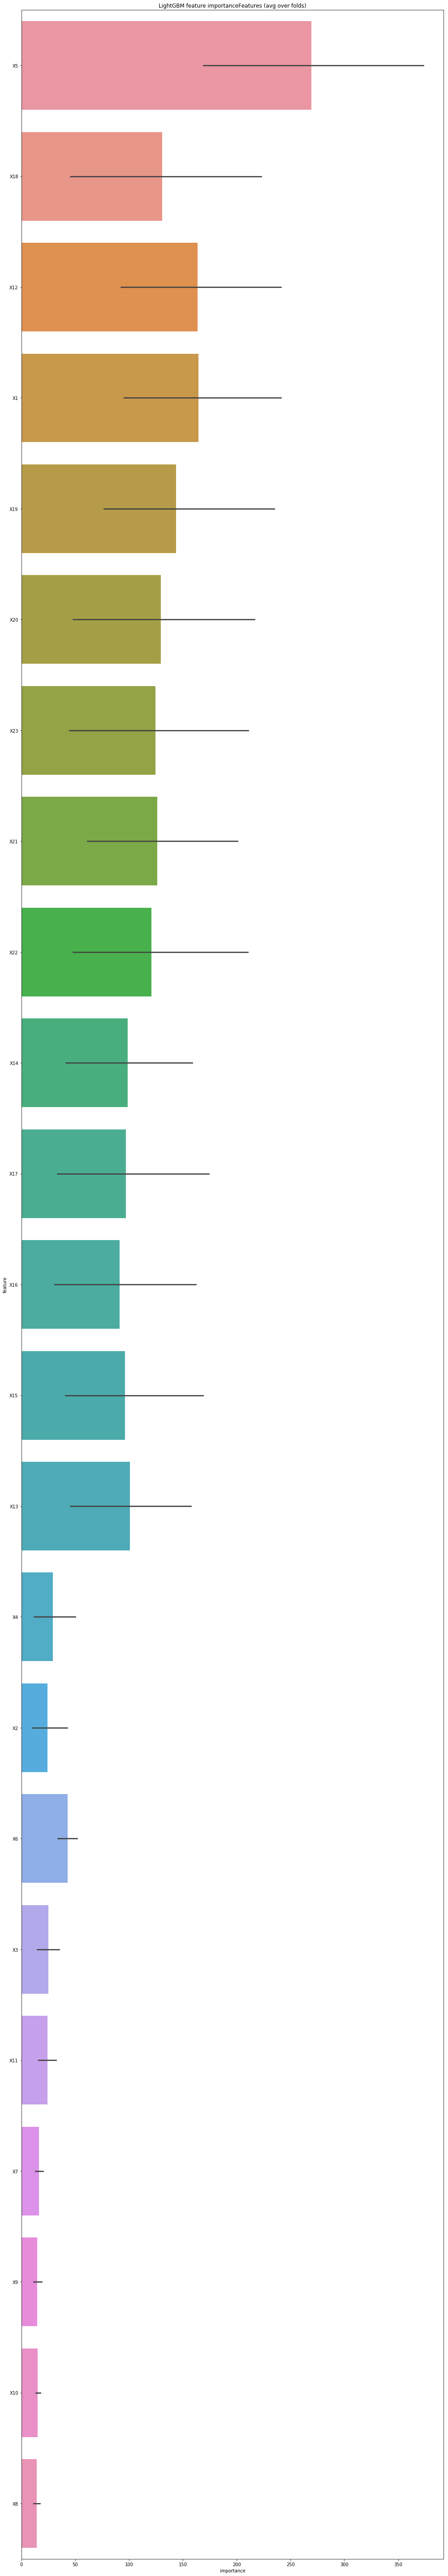

In [19]:
# create lightgbm importance display
LightGBM.display_importances(importances, title="LightGBM feature importance")

# Parameter tuning (optune)

## Lightgbm

lightgbm を例にして, パラメータチューニング

In [39]:
# tuning
study = optuna.create_study()
data = partial(LightGBM.tuning, train, features)
study.optimize(data, n_trials=10)

fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:05:11,437] Finished trial#0 resulted in value: 1.0. Current best value is 1.0 with parameters: {'boosting': 'gbdt', 'num_leaves': 10, 'learning_rate': 3.133714846739265e-06}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:07:42,311] Finished trial#1 resulted in value: 1.0. Current best value is 1.0 with parameters: {'boosting': 'gbdt', 'num_leaves': 10, 'learning_rate': 3.133714846739265e-06}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0523611	valid_1's binary_error: 0.180926
[200]	training's binary_error: 0.0104167	valid_1's binary_error: 0.183148
Early stopping, best iteration is:
[36]	training's binary_error: 0.134028	valid_1's binary_error: 0.178148
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0543056	valid_1's binary_error: 0.182778
[200]	training's binary_error: 0.011713	valid_1's binary_error: 0.181852
Early stopping, best iteration is:
[43]	training's binary_error: 0.12463	valid_1's binary_error: 0.177222
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0502778	valid_1's binary_error: 0.184259
[200]	training's binary_error: 0.0105093	valid_1's binary_error: 0.187593
Early stopping, best iteration is:
[47]	training's binary_error: 0.120602	valid_1's binary_error: 0.181111
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0533333	valid_1's binary_error: 0.190741
[200]	training's binary_error: 0.0108333	valid_1's binary_error: 0.19
Early stopping, best iteration is:
[53]	training's binary_error: 0.111111	valid_1's binary_error: 0.188333
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0513426	valid_1's binary_error: 0.183333
[200]	training's binary_error: 0.00930556	valid_1's binary_error: 0.18537
[300]	training's binary_error: 0.00342593	valid_1's binary_error: 0.182593
[400]	training's binary_error: 0.00185185	valid_1's binary_error: 0.185926
Early stopping, best iteration is:
[298]	training's binary_error: 0.00347222	valid_1's binary_error: 0.181852


[I 2019-04-21 01:09:03,794] Finished trial#2 resulted in value: 0.5300235655822407. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:11:06,753] Finished trial#3 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:13:34,115] Finished trial#4 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:17:20,700] Finished trial#5 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000787037	valid_1's binary_error: 0.199815
[200]	training's binary_error: 0.000787037	valid_1's binary_error: 0.198333
Early stopping, best iteration is:
[1]	training's binary_error: 0.168519	valid_1's binary_error: 0.188519
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000740741	valid_1's binary_error: 0.19463
[200]	training's binary_error: 0.000740741	valid_1's binary_error: 0.193333
Early stopping, best iteration is:
[45]	training's binary_error: 0.000740741	valid_1's binary_error: 0.193519
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000555556	valid_1's binary_error: 0.199074
[200]	training's binary_error: 0.000555556	valid_1's binary_error: 0.200556
Early stopping, best iteration is:
[2]	training's binary_error: 0.144583	valid_1's binary_error: 0.195
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000555556	valid_1's binary_error: 0.204815
[200]	training's binary_error: 0.000555556	valid_1's binary_error: 0.20463
Early stopping, best iteration is:
[37]	training's binary_error: 0.000555556	valid_1's binary_error: 0.202222
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000601852	valid_1's binary_error: 0.193148
[200]	training's binary_error: 0.000601852	valid_1's binary_error: 0.196296
Early stopping, best iteration is:
[42]	training's binary_error: 0.000601852	valid_1's binary_error: 0.200185


[I 2019-04-21 01:18:43,028] Finished trial#6 resulted in value: 0.5660410356626291. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:21:18,841] Finished trial#7 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:23:04,894] Finished trial#8 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0823611	valid_1's binary_error: 0.183889
[200]	training's binary_error: 0.00912037	valid_1's binary_error: 0.184444
Early stopping, best iteration is:
[74]	training's binary_error: 0.113009	valid_1's binary_error: 0.182778
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0813889	valid_1's binary_error: 0.179444
[200]	training's binary_error: 0.00884259	valid_1's binary_error: 0.180741
[300]	training's binary_error: 0.0037037	valid_1's binary_error: 0.182037
Early stopping, best iteration is:
[149]	training's binary_error: 0.0273611	valid_1's binary_error: 0.176852
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0815741	valid_1's binary_error: 0.18463
[200]	training's binary_error: 0.00907407	valid_1's binary_error: 0.184444
Early stopping, best iteration is:
[58]	training's binary_error: 0.130093	valid_1's binary_error: 0.182407
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0786574	valid_1's binary_error: 0.187593
[200]	training's binary_error: 0.00925926	valid_1's binary_error: 0.190926
Early stopping, best iteration is:
[83]	training's binary_error: 0.100741	valid_1's binary_error: 0.186481
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.079537	valid_1's binary_error: 0.186111
[200]	training's binary_error: 0.00916667	valid_1's binary_error: 0.186481
Early stopping, best iteration is:
[80]	training's binary_error: 0.103287	valid_1's binary_error: 0.183889


[I 2019-04-21 01:25:54,832] Finished trial#9 resulted in value: 0.5548632536542228. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


In [42]:
# best params
print('Number of finished trials: {}'.format(len(study.trials)))
print('best value: {}'.format(study.best_trial.value))
print('Lightgbm Best params:', study.best_params)

Number of finished trials: 10
best value: 0.5300235655822407
params: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}


In [44]:
# using best parameters
ans = LightGBM.prediction(train,test,features,study.best_params)

fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0523611	valid_1's binary_error: 0.180926
[200]	training's binary_error: 0.0104167	valid_1's binary_error: 0.183148
Early stopping, best iteration is:
[36]	training's binary_error: 0.134028	valid_1's binary_error: 0.178148
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0543056	valid_1's binary_error: 0.182778
[200]	training's binary_error: 0.011713	valid_1's binary_error: 0.181852
Early stopping, best iteration is:
[43]	training's binary_error: 0.12463	valid_1's binary_error: 0.177222
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0502778	valid_1's binary_error: 0.184259
[200]	training's binary_error: 0.0105093	valid_1's binary_error: 0.187593
Early stopping, best iteration is:
[47]	training's binary_error: 0.120602	valid_1's binary_error: 0.181111
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0533333	valid_1's binary_error: 0.190741
[200]	training's binary_error: 0.0108333	valid_1's binary_error: 0.19
Early stopping, best iteration is:
[53]	training's binary_error: 0.111111	valid_1's binary_error: 0.188333
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0513426	valid_1's binary_error: 0.183333
[200]	training's binary_error: 0.00930556	valid_1's binary_error: 0.18537
[300]	training's binary_error: 0.00342593	valid_1's binary_error: 0.182593
[400]	training's binary_error: 0.00185185	valid_1's binary_error: 0.185926
Early stopping, best iteration is:
[298]	training's binary_error: 0.00347222	valid_1's binary_error: 0.181852


In [109]:
# target rate
print('train data rate:', Counter(train['y']))
print('test data rate:', Counter(ans))
# sample submit
# Process.submit(ans,tech="lightgbm_optuna")
Process.save_parameter(study.best_params,file_name = 'lgb_tune_param')

## Decision Tree

In [16]:
# tuning
study = optuna.create_study()
data = partial(DecisionTree.tuning, train, features)
study.optimize(data, n_trials=50)

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:18,746] Finished trial#0 resulted in value: 0.5852009147544602. Current best value is 0.5852009147544602 with parameters: {'max_depth': 19, 'criterion': 'entropy', 'min_samples_leaf': 6}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:20,631] Finished trial#1 resulted in value: 0.5366084564335922. Current best value is 0.5366084564335922 with parameters: {'max_depth': 11, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:20,902] Finished trial#2 resulted in value: 0.5555320184248534. Current best value is 0.5366084564335922 with parameters: {'max_depth': 11, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:22,928] Finished trial#3 resulted in value: 0.5366084564335922. Current best value is 0.5366084564335922 with parameters: {'max_depth': 11, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:23,786] Finished trial#4 resulted in value: 0.5249317823528299. Current best value is 0.5249317823528299 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 7}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:26,230] Finished trial#5 resulted in value: 0.5764682075151466. Current best value is 0.5249317823528299 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 7}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:27,839] Finished trial#6 resulted in value: 0.564386391619671. Current best value is 0.5249317823528299 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 7}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:29,210] Finished trial#7 resulted in value: 0.5277806170950481. Current best value is 0.5249317823528299 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 7}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:29,661] Finished trial#8 resulted in value: 0.56079788344381. Current best value is 0.5249317823528299 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 7}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:31,663] Finished trial#9 resulted in value: 0.5545776657223385. Current best value is 0.5249317823528299 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 7}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:32,417] Finished trial#10 resulted in value: 0.5286325074872813. Current best value is 0.5249317823528299 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 7}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:33,278] Finished trial#11 resulted in value: 0.5220648834242368. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:33,794] Finished trial#12 resulted in value: 0.5304235689542549. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:34,879] Finished trial#13 resulted in value: 0.5317976324496441. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:35,631] Finished trial#14 resulted in value: 0.5288108658082068. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:37,488] Finished trial#15 resulted in value: 0.5680559959427632. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:38,724] Finished trial#16 resulted in value: 0.5337552105385258. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:39,562] Finished trial#17 resulted in value: 0.5286325074872813. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:40,648] Finished trial#18 resulted in value: 0.529509036498826. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:41,221] Finished trial#19 resulted in value: 0.5304235689542549. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:42,193] Finished trial#20 resulted in value: 0.5249317823528299. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:43,579] Finished trial#21 resulted in value: 0.5422087595352005. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:45,085] Finished trial#22 resulted in value: 0.5422087595352005. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:45,636] Finished trial#23 resulted in value: 0.5304235689542549. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:46,374] Finished trial#24 resulted in value: 0.5278908487101176. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:47,729] Finished trial#25 resulted in value: 0.533598861681036. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:48,058] Finished trial#26 resulted in value: 0.5555320184248534. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:49,750] Finished trial#27 resulted in value: 0.5443881756414937. Current best value is 0.5220648834242368 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 3}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:50,663] Finished trial#28 resulted in value: 0.5216985128805024. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:53,012] Finished trial#29 resulted in value: 0.5840731099249016. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:54,185] Finished trial#30 resulted in value: 0.5230051646951909. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:54,502] Finished trial#31 resulted in value: 0.5555320184248534. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:57,136] Finished trial#32 resulted in value: 0.5536235767538824. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:06:58,798] Finished trial#33 resulted in value: 0.5428789272270161. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:00,556] Finished trial#34 resulted in value: 0.530715100586539. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:02,817] Finished trial#35 resulted in value: 0.5780765636395176. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:03,945] Finished trial#36 resulted in value: 0.525853456992347. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:04,866] Finished trial#37 resulted in value: 0.5363732029746762. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:05,347] Finished trial#38 resulted in value: 0.5631385237053008. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:07,238] Finished trial#39 resulted in value: 0.5410645751282661. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:08,400] Finished trial#40 resulted in value: 0.5279979711200139. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:09,692] Finished trial#41 resulted in value: 0.5366118990729097. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:12,172] Finished trial#42 resulted in value: 0.5468603090523919. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:12,922] Finished trial#43 resulted in value: 0.5278908487101176. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:13,392] Finished trial#44 resulted in value: 0.5631385237053008. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:14,381] Finished trial#45 resulted in value: 0.5245516355395143. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:16,006] Finished trial#46 resulted in value: 0.5285236213204725. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:18,015] Finished trial#47 resulted in value: 0.544099429220099. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:18,920] Finished trial#48 resulted in value: 0.5289054583610089. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-22 22:07:19,996] Finished trial#49 resulted in value: 0.5252874982616925. Current best value is 0.5216985128805024 with parameters: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}.


In [18]:
# best params
print('Number of finished trials: {}'.format(len(study.trials)))
print('best value: {}'.format(study.best_trial.value))
print('Dicision Tree best params:', study.best_params)

# save params
# Process.save_parameter(study.best_params,file_name = 'Tree_classifer_param')

Number of finished trials: 50
best value: 0.5216985128805024
Dicision Tree best params: {'max_depth': 6, 'criterion': 'gini', 'min_samples_leaf': 2}


In [85]:
# using best parameters
ans = DecisionTree.prediction(train,test,features,study.best_params)

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


In [36]:
# target rate
print('train data rate:', Counter(train['y']))
print('test data rate:', Counter(ans))
# sample submit
# Process.submit(ans,tech="decisiontree_optuna")

train data rate: Counter({0: 21006, 1: 5994})


NameError: name 'ans' is not defined

# other technic

## Down sampling (imblance module)

- 二値分類において, 偏りがある場合少数データに合わせて, 偏りをなくす方法

In [12]:
data = Applicate.down_sampling(train,features,rate=3)
data.head()

original data rate: Counter({0: 21006, 1: 5994})
down sampling data rate: Counter({0: 17982, 1: 5994})


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
0,90000,2,2,1,47,0,0,0,0,0,...,28747,29177,29452,2000,2000,2000,2000,2000,2000,0
1,150000,2,1,1,36,-2,-2,-2,-2,-2,...,25172,4694,6292,13447,17914,25349,4694,6324,14433,0
2,30000,1,3,1,48,-1,-1,-1,-1,-1,...,1261,1261,1261,1261,1261,1261,1261,1261,1261,0
3,30000,2,3,1,47,1,2,2,2,0,...,14369,15333,16289,1000,900,1000,1200,1200,1200,0
4,320000,2,2,2,33,0,0,0,0,0,...,65913,43805,33263,10042,18832,2117,2076,5045,3754,0


## Feature Engineering by Genetic Algorithm

In [81]:
# base score
params = {'random_state': 831,'max_depth': 7, 
          'criterion': 'entropy', 'min_samples_leaf': 9}
base_score = DecisionTree.validation(train,features,params)
print("validation mean score:", base_score['score'].mean())

validation mean score: 0.47451138809621096


In [82]:
# 除算関数の定義
# 左項 / 右項で右項が0の場合1を代入する
def protectedDiv(left, right):
    eps = 1.0e-7
    tmp = np.zeros(len(left))
    tmp[np.abs(right) >= eps] = left[np.abs(right) >= eps] / right[np.abs(right) >= eps]
    tmp[np.abs(right) < eps] = 1.0
    return tmp

# 適合度を最大化するような木構造を個体として定義
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

/Users/takutokotsubo/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/takutokotsubo/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


In [83]:
# setting
prev_score = np.mean(base_score['score']) # base score
exprs = [] # 生成した特徴量
results = pd.DataFrame(columns=['n_features','best_score','val_score']) # 結果を格納する. (best_score == val_score ??)

# data
n_features = test.shape[1] # 初期時点の特徴量数
X_train = train[features]
y_train = train['y']

In [84]:
# main
for i in tqdm(range(100)):
    pset = gp.PrimitiveSet("MAIN", n_features)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(np.cos, 1)
    pset.addPrimitive(np.sin, 1)
    pset.addPrimitive(np.tan, 1)

    # 関数のデフォルト値の設定
    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr) 
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    def eval_genfeat(individual):
        func = toolbox.compile(expr=individual)
        # make new features
        features_train = [np.array(X_train)[:,j] for j in range(n_features)]
        new_feat_train = func(*features_train)
        # combine table and select features name
        train_tmp = pd.concat([X_train,pd.DataFrame(new_feat_train,columns=['tmp']),y_train],axis=1)
        features_tmp = train_tmp.drop("y",axis=1).columns.values
        tmp_score = DecisionTree.validation(train_tmp,features_tmp,params)
        # print(np.mean(tmp_score['score']))
        return np.mean(tmp_score['score']),

    # 評価、選択、交叉、突然変異の設定
    # 選択はサイズ10のトーナメント方式、交叉は1点交叉、突然変異は深さ2のランダム構文木生成と定義
    toolbox.register("evaluate", eval_genfeat)
    toolbox.register("select", tools.selTournament, tournsize=10)
    toolbox.register("mate", gp.cxOnePoint)
    toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
    toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    # 構文木の制約の設定
    # 交叉や突然変異で深さ5以上の木ができないようにする
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=5)) 

    # 世代ごとの個体とベスト解を保持するクラスの生成
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(1)

    # 統計量の表示設定
    stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
    stats_size = tools.Statistics(len)
    mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
    mstats.register("avg", np.mean)
    mstats.register("std", np.std)
    mstats.register("min", np.min)
    mstats.register("max", np.max)

    # 進化の実行
    # 交叉確率50%、突然変異確率10%、10世代まで進化
    start_time = time.time()
    pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.1, 10, stats=mstats, halloffame=hof, verbose=True)
    end_time = time.time()

    # ベスト解とscoreの保持
    best_expr = hof[0]
    best_score = mstats.compile(pop)["fitness"]["max"]

    # 生成変数を学習、テストデータに追加し、ベストスコアを更新する
    if prev_score < best_score:
        # 生成変数の追加
        func = toolbox.compile(expr=best_expr)
        features_train = [np.array(X_train)[:,j] for j in range(n_features)]
        features_test = [np.array(test)[:,j] for j in range(n_features)]
        new_feat_train = func(*features_train)
        new_feat_test = func(*features_test)
        # データ更新
        X_train = pd.concat([X_train,pd.DataFrame(new_feat_train,columns=['NEW'+ str(i)])],axis=1)
        test = pd.concat([test,pd.DataFrame(new_feat_test,columns=['NEW'+ str(i)])],axis=1)
        new_features = X_train.columns.values
        # テストスコアの計算（プロット用）
        val_score = DecisionTree.validation(pd.concat([X_train,y_train],axis=1),new_features,params)
        # test_pred = DecisionTree.prediction(train,test,features,params)

        # ベストスコアの更新と特徴量数の加算
        prev_score = best_score
        n_features += 1
        # 表示と出力用データの保持
        print("n_features: %i, best_score: %f, time: %f second"
              % (n_features, best_score, end_time - start_time))
        # 結果の格納 ( スコアの記録と作成した特徴量)
        tmp = pd.Series( [n_features, best_score, np.mean(val_score['score'])], index=results.columns )
        results = results.append( tmp, ignore_index=True )
        exprs.append(best_expr)

        # 変数追加後の特徴量数が60を超えた場合break
        if n_features >= 60:
            break










  0%|          | 0/5 [00:00<?, ?it/s]

   	      	                     fitness                      	              size             
   	      	--------------------------------------------------	-------------------------------
gen	nevals	avg     	max    	min     	std       	avg 	max	min	std    
0  	300   	0.474028	0.48247	0.461835	0.00296416	4.22	13 	2  	2.49365
1  	161   	0.47663 	0.48247	0.464762	0.00328558	4.72	13 	2  	2.78836
2  	184   	0.477306	0.48247	0.461739	0.00390288	5.34	17 	1  	3.37704
3  	162   	0.478385	0.490042	0.455178	0.00433047	5.75667	20 	1  	3.4858 
4  	162   	0.478852	0.490042	0.467289	0.00445341	4.80667	15 	1  	2.29549
5  	151   	0.479573	0.490042	0.461555	0.0054886 	6.44667	14 	1  	2.83793
6  	180   	0.479948	0.490042	0.461088	0.00688632	7.84   	16 	1  	2.50621
7  	173   	0.482531	0.490042	0.461555	0.00786424	7.23333	14 	1  	1.55742
8  	182   	0.482252	0.490042	0.461555	0.008702  	7      	13 	1  	1.22746
9  	175   	0.483158	0.490706	0.461555	0.00802029	7.02   	13 	1  	1.36122
10 	181   	0.483453	0.490










 20%|██        | 1/5 [24:01<1:36:07, 1441.83s/it]

   	      	                         fitness                          	              size             
   	      	----------------------------------------------------------	-------------------------------
gen	nevals	avg     	max     	min     	std       	avg    	max	min	std    
0  	300   	0.490233	0.495801	0.468356	0.00352187	3.87333	14 	2  	2.44349
1  	148   	0.49188 	0.495801	0.476329	0.00270369	3.72333	13 	1  	2.04453
2  	137   	0.492688	0.495801	0.468519	0.00360837	3.54333	12 	1  	1.82431
3  	166   	0.493476	0.495801	0.477655	0.00319332	3.44   	9  	1  	1.33656
4  	178   	0.493939	0.495801	0.483083	0.0025161 	3.09667	8  	1  	0.673787
5  	195   	0.493934	0.495801	0.481738	0.00274772	3.07   	9  	1  	0.609727
6  	165   	0.493653	0.495801	0.469462	0.0039254 	3.18   	8  	1  	0.800583
7  	180   	0.494092	0.495801	0.476172	0.00294793	3.10667	8  	1  	0.68456 
8  	164   	0.494066	0.495801	0.47737 	0.00286122	3.17   	9  	1  	0.876223
9  	153   	0.4941  	0.495801	0.477655	0.00277017	3.06333	8  	

IndexError: index 23 is out of bounds for axis 1 with size 23

In [95]:
# result
print("### Generated feature expression")
for expr in exprs:
    print(expr)
    
print("### Result")
print(results)

### Generated feature expression
neg(protectedDiv(ARG13, ARG10))
### Result
   n_features  best_score  val_score
0        24.0    0.490706   0.490706
